<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-fundamentals/unit06-deep-learning-tips-and-tricks/02_lightning_learning_rate_schedulers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Rate Schedulers

**Reference**

[Learning Rates and Learning Rate Schedulers](https://lightning.ai/pages/courses/deep-learning-fundamentals/unit-6-overview-essential-deep-learning-tips-tricks/unit-6.2-learning-rates-and-learning-rate-schedulers/)

## 1) Setup

In [1]:
!pip install torch torchvision torchaudio
!pip install lightning
!pip install torchmetrics
!pip install mlxtend==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 8.9 MB/s eta 0:00:00

In [2]:
!lightning --version

lightning, version 2.0.2


In [3]:
!wget https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit06-dl-tips/6.2-learning-rates/shared_utilities.py

--2023-05-04 13:39:27--  https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit06-dl-tips/6.2-learning-rates/shared_utilities.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Lightning-AI/dl-fundamentals/main/unit06-dl-tips/6.2-learning-rates/shared_utilities.py [following]
--2023-05-04 13:39:27--  https://raw.githubusercontent.com/Lightning-AI/dl-fundamentals/main/unit06-dl-tips/6.2-learning-rates/shared_utilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5031 (4.9K) [text/plain]
Saving to: ‘shared_utilities.py’

shared_utilities.py 100%[===================>]   4.91K  --.-KB/s

In [4]:
import torch
import torchvision
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import torchmetrics as tm

from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler

from shared_utilities import CustomDataModule, LightningModel, PyTorchMLP

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
def show_metrics(trainer):
  metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

  aggreg_metrics = []
  agg_col = "epoch"
  for i, dfg in metrics.groupby(agg_col):
      agg = dict(dfg.mean())
      agg[agg_col] = i
      aggreg_metrics.append(agg)

  df_metrics = pd.DataFrame(aggreg_metrics)
  df_metrics[["train_loss", "val_loss"]].plot(
      grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
  )

  plt.savefig("suggest_loss.pdf")

  df_metrics[["train_acc", "val_acc"]].plot(
      grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
  )

  plt.show()

In [6]:
!mkdir -p my_logs

## 2) Learning Rate Finder

In [ ]:
torch.manual_seed(123)

dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

In [ ]:
torch.manual_seed(123)

print("Torch CUDA available?", torch.cuda.is_available())

trainer = L.Trainer(
  max_epochs=100,
  accelerator="auto", # set to "auto" or "gpu" to use GPUs if available
  devices="auto",      # Uses all available GPUs if applicable
  deterministic=True,
  logger=CSVLogger(save_dir="my_logs", name="my-model")
)

# Create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically 
# sets hparams.lr or hparams.learning_rate to that learning rate
lr_finder = tuner.lr_find(
  model=lightning_model,
  datamodule=dm
)

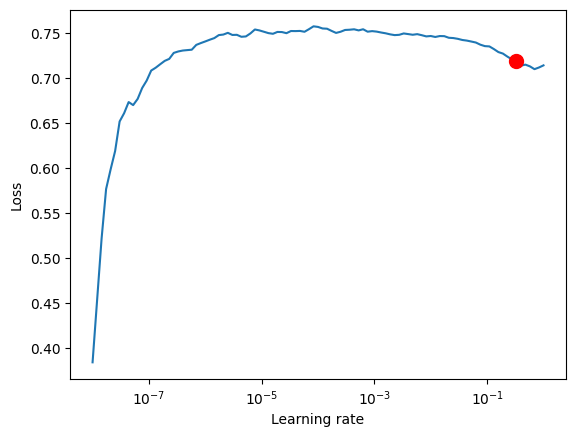

In [ ]:
fig = lr_finder.plot(suggest=True)

In [ ]:
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

0.3311311214825908


In [ ]:
# update hparams of the model
lightning_model.learning_rate = new_lr

In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)

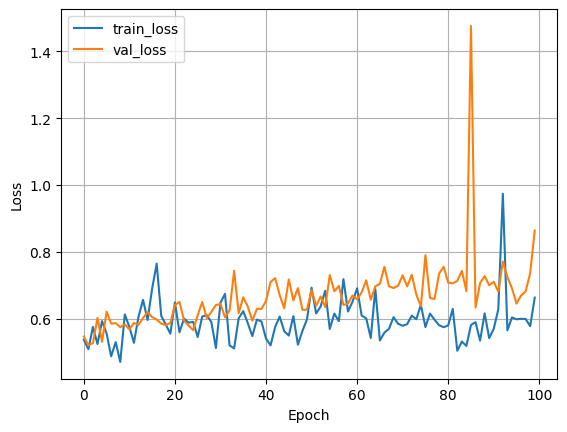

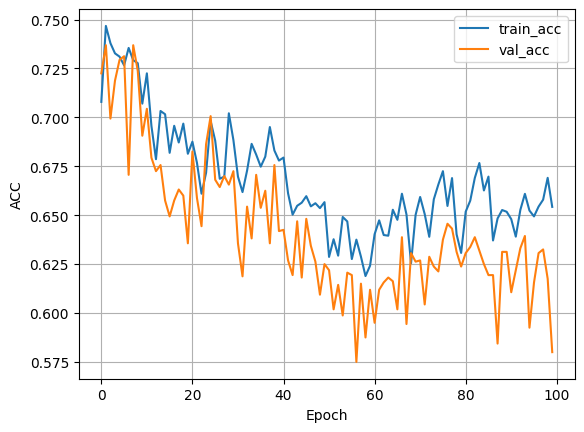

In [ ]:
show_metrics(trainer)

In [ ]:
trainer.test(model=lightning_model, datamodule=dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5932499766349792     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5932499766349792}]

##3) No Scheduler

In [ ]:
torch.manual_seed(123)

dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
  max_epochs=100,
  accelerator="auto", # set to "auto" or "gpu" to use GPUs if available
  devices="auto",      # Uses all available GPUs if applicable
  deterministic=True,
  logger=CSVLogger(save_dir="logs_v1", name="my-model")
)

trainer.fit(
  model=lightning_model,
  datamodule=dm
)

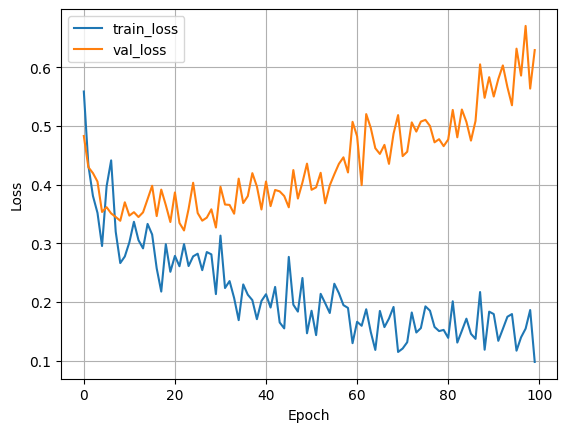

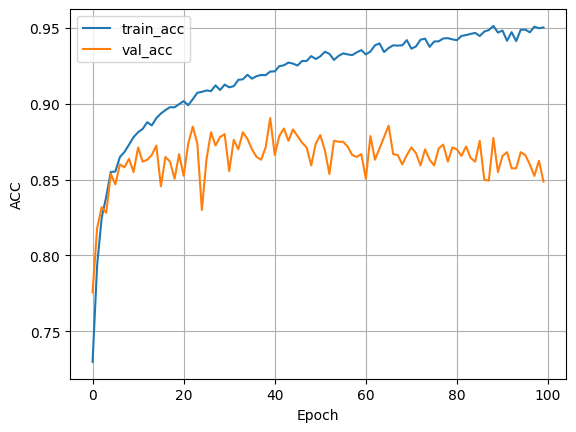

In [ ]:
show_metrics(trainer)

In [ ]:
trainer.test(model=lightning_model, dataloaders=dm.val_dataloader())

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8487499952316284     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8487499952316284}]

##4) Step Scheduler

In [ ]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = tm.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = tm.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = tm.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizers = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        schedulers = torch.optim.lr_scheduler.StepLR(optimizers, step_size=10, gamma=0.5)

        return [optimizers], [schedulers]
        
        """ 
        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 10
            },
        }
        """

In [ ]:
L.seed_everything(123)

dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
  max_epochs=100,
  accelerator="auto", # set to "auto" or "gpu" to use GPUs if available
  devices="auto",      # Uses all available GPUs if applicable
  deterministic=True,
  logger=CSVLogger(save_dir="logs_v1", name="my-model")
)

trainer.fit(
  model=lightning_model,
  datamodule=dm
)

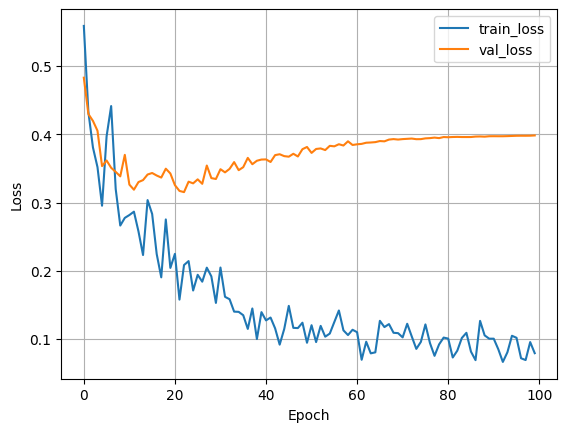

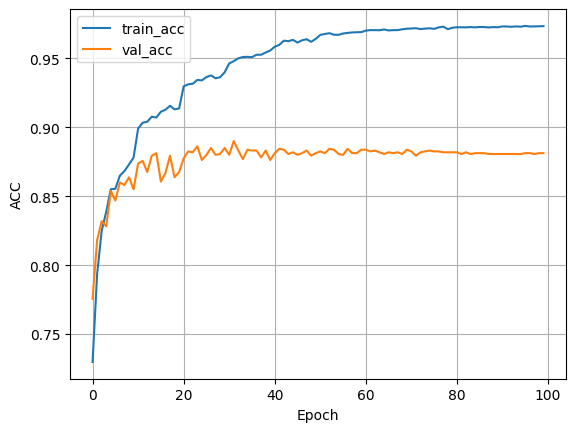

In [ ]:
show_metrics(trainer)

In [ ]:
trainer.test(model=lightning_model, dataloaders=dm.val_dataloader())

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8812500238418579     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8812500238418579}]

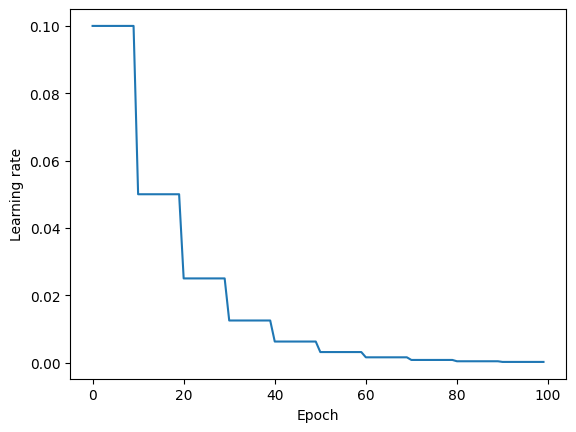

In [ ]:
opt = torch.optim.SGD(pytorch_model.parameters(), lr=0.1)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

lrs = []
max_epochs = 100

for epoch in range(max_epochs):
    opt.step()
    lrs.append(opt.param_groups[0]["lr"])
    sch.step()

plt.plot(range(max_epochs), lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

plt.show()

##5) Reduce-on-Plateau Scheduler

In [7]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = tm.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = tm.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = tm.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizers = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        schedulers = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers, mode="min", factor=0.1, patience=5)

        return {
            "optimizer": optimizers,
            "lr_scheduler": {
                "scheduler": schedulers,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1
            },
        }
        

In [ ]:
L.seed_everything(123)

dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
  max_epochs=100,
  accelerator="auto", # set to "auto" or "gpu" to use GPUs if available
  devices="auto",      # Uses all available GPUs if applicable
  deterministic=True,
  logger=CSVLogger(save_dir="logs_v1", name="my-model")
)

trainer.fit(
  model=lightning_model,
  datamodule=dm
)

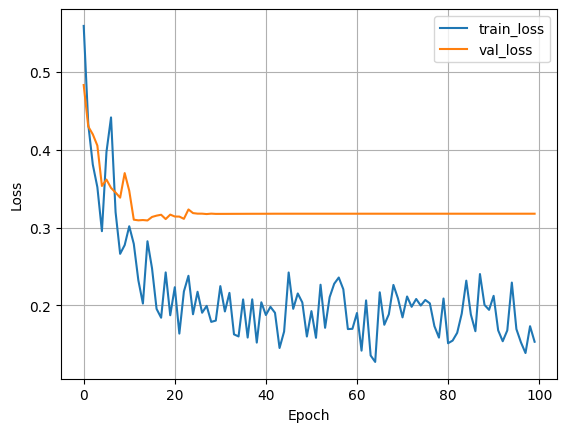

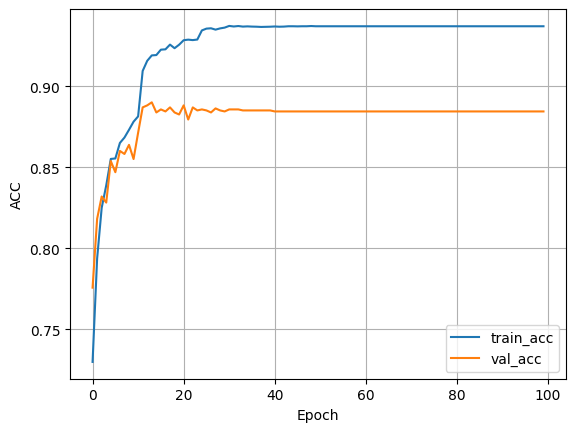

In [11]:
show_metrics(trainer)

In [12]:
trainer.test(model=lightning_model, dataloaders=dm.val_dataloader())

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8843749761581421     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8843749761581421}]

##6) Cosine Annealing Scheduler